## 匯入所需套件

In [1]:
import pandas as pd
import numpy as np
# import matplotlib_inline as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
sns.set_palette('pastel')
# sns.set_palette('husl',3)
sns.set_style('darkgrid')
# sns.set_style('whitegrid')
%config inlineBackend.figure_format = 'retina'

## 讀進航班母檔

In [20]:
EDA_pt = pd.read_csv('../US_1722_flights_info_IQR.csv', usecols=['actu_duration','delay_duration','delay_dest','delay_depa'])

In [21]:
EDA_pt.shape

(29881671, 4)

In [22]:
EDA_pt.isna().sum()

actu_duration     0
delay_depa        0
delay_duration    0
delay_dest        0
dtype: int64

## 把delay分級距

In [23]:
## 把delay分級級距
bins = [-np.inf, 5, 10, 15, 20, 25, 30, np.inf]
EDA_pt['delay_depa_cate'] = pd.cut(EDA_pt['delay_depa'], bins=bins, labels=[0, 1, 2, 3, 4, 5, 6])

In [24]:
## 把delay分級級距
# bins = [-np.inf, 1, 15, 30, 45, 60, 75, 90, 105, 120,135,150,165,180,np.inf]
# EDA_pt['delay_depa_cate'] = pd.cut(EDA_pt['delay_depa'], bins=bins, labels=[0, 1,2, 3, 4, 5, 6, 7,8,9,10,11,12,13])

In [25]:
EDA_pt['delay_depa_cate'].value_counts()

0    25842309
1     1669443
2     1146116
3      831524
4      392279
5           0
6           0
Name: delay_depa_cate, dtype: int64

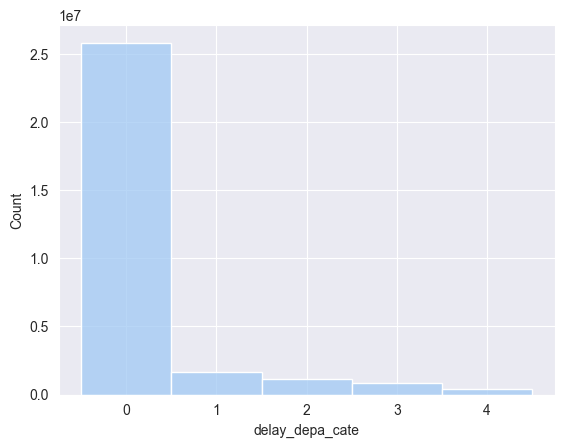

In [14]:
sns.histplot(data=EDA_pt[['delay_depa_cate']], x="delay_depa_cate" )
plt.show()

## 取得出勤航班 以及當中有延誤出發的航班

In [26]:
## 取得出勤航班
#篩掉取消航班，留下真的有飛的航班
# EDA_pt_act=EDA_pt[EDA_pt['actu_depa_hr'] + EDA_pt['actu_depa_min']  +  EDA_pt['actu_duration'] != 0]
total_flight = EDA_pt[EDA_pt['actu_duration'] != 0]
total_flight.shape

(29881671, 5)

In [27]:
## 取得delay航班數
#先篩選出有delay的出勤航班 再以航班分組
# delay_counts = EDA_pt_act.groupby('flight_num')
delay_counts = total_flight[total_flight['delay_depa'] > 5]
# delay_counts = delay_counts.rbeset_index(drop=False)
delay_counts

,actu_duration,delay_depa,delay_duration,delay_dest,delay_depa_cate
26,118.0,17.0,-18.0,-1.0,3
45,144.0,17.0,9.0,26.0,3
48,133.0,6.0,-2.0,4.0,1
58,142.0,16.0,12.0,28.0,3
62,137.0,13.0,7.0,20.0,2
...,...,...,...,...,...
29881593,52.0,21.0,-5.0,16.0,4
29881615,70.0,6.0,12.0,18.0,1
29881622,51.0,7.0,-4.0,3.0,1
29881625,48.0,6.0,-7.0,-1.0,1


## 取得實際飛航時間與預計飛航時間的差異

In [28]:
delay_counts[['delay_duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
delay_duration,4039362.0,-7.138949,10.867253,-69.0,-14.0,-8.0,-1.0,31.0


## 把實際飛航時間與預計飛航時間差異 編碼 1 有趕時間(實際比預計小 小於0) 0沒趕時間(實際比預計大 大於0)

In [29]:
delay_counts['act_sche_diff_cate'] = delay_counts['delay_duration'].apply(lambda x : 0 if x >=0 else 1)
delay_counts[['act_sche_diff_cate']].value_counts()

C:\Users\terra\AppData\Local\Temp\ipykernel_17568\519652522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_counts['act_sche_diff_cate'] = delay_counts['delay_duration'].apply(lambda x : 0 if x >=0 else 1)


act_sche_diff_cate
1                     3056241
0                      983121
dtype: int64

In [30]:
delay_counts

,actu_duration,delay_depa,delay_duration,delay_dest,delay_depa_cate,act_sche_diff_cate
26,118.0,17.0,-18.0,-1.0,3,1
45,144.0,17.0,9.0,26.0,3,0
48,133.0,6.0,-2.0,4.0,1,1
58,142.0,16.0,12.0,28.0,3,0
62,137.0,13.0,7.0,20.0,2,0
...,...,...,...,...,...,...
29881593,52.0,21.0,-5.0,16.0,4,1
29881615,70.0,6.0,12.0,18.0,1,0
29881622,51.0,7.0,-4.0,3.0,1,1
29881625,48.0,6.0,-7.0,-1.0,1,1


In [31]:
delay_counts_act_diff = delay_counts[['delay_depa_cate','delay_duration','act_sche_diff_cate']]
# delay_counts_act_diff = delay_counts_act_diff[delay_counts_act_diff['delay_depa_cate']>0].sort_values('delay_depa_cate')
delay_counts_act_diff['act_sche_diff_cate_1'] =  delay_counts_act_diff['act_sche_diff_cate'].apply(lambda x : 1 if x==1 else 0)
delay_counts_act_diff['act_sche_diff_cate_0'] =  delay_counts_act_diff['act_sche_diff_cate'].apply(lambda x : 0 if x==0 else 1)


C:\Users\terra\AppData\Local\Temp\ipykernel_17568\2339416042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_counts_act_diff['act_sche_diff_cate_1'] =  delay_counts_act_diff['act_sche_diff_cate'].apply(lambda x : 1 if x==1 else 0)
C:\Users\terra\AppData\Local\Temp\ipykernel_17568\2339416042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_counts_act_diff['act_sche_diff_cate_0'] =  delay_counts_act_diff['act_sche_diff_cate'].apply(lambda x : 0 if x==0 else 1)


In [32]:
delay_counts_act_diff

,delay_depa_cate,delay_duration,act_sche_diff_cate,act_sche_diff_cate_1,act_sche_diff_cate_0
26,3,-18.0,1,1,1
45,3,9.0,0,0,0
48,1,-2.0,1,1,1
58,3,12.0,0,0,0
62,2,7.0,0,0,0
...,...,...,...,...,...
29881593,4,-5.0,1,1,1
29881615,1,12.0,0,0,0
29881622,1,-4.0,1,1,1
29881625,1,-7.0,1,1,1


In [76]:
delay_counts_act_diff_plt = delay_counts_act_diff.groupby(['delay_depa_cate','act_sche_diff_cate']).count()
delay_counts_act_diff_plt

delay_duration  act_sche_diff_cate_1  \
delay_depa_cate act_sche_diff_cate                                         
0               0                                0                     0   
                1                                0                     0   
1               0                           419997                419997   
                1                          1249446               1249446   
2               0                           281315                281315   
                1                           864801                864801   
3               0                           195228                195228   
                1                           636296                636296   
4               0                            86581                 86581   
                1                           305698                305698   
5               0                                0                     0   
                1                                0                     0   
6               0                                0                     0   
                1                                0                     0   

                                    act_sche_diff_cate_0  
delay_depa_cate act_sche_diff_cate                        
0               0                                      0  
                1                                      0  
1               0                                 419997  
                1                                1249446  
2               0                                 281315  
                1                                 864801  
3               0                                 195228  
                1                                 636296  
4               0                                  86581  
                1                                 305698  
5               0                                      0  
                1                                      0  
6               0                                      0  
                1                                      0

In [77]:
delay_counts_act_diff_plt = delay_counts_act_diff_plt[['delay_duration']]
delay_counts_act_diff_plt = delay_counts_act_diff_plt.unstack()
# x=['0~15','15~30','30~45','45~60','60~75','75~90','90~105','105~120','120~135','135~150','150~165','165~180','180~']
# df = pd.Series(x)
# df
# delay_counts_act_diff_plt = delay_counts_act_diff_plt.append(df,ignore_index=True)
delay_counts_act_diff_plt

delay_duration         
act_sche_diff_cate              0        1
delay_depa_cate                           
0                               0        0
1                          419997  1249446
2                          281315   864801
3                          195228   636296
4                           86581   305698
5                               0        0
6                               0        0

In [67]:
delay_counts_act_diff_plt.columns

MultiIndex([(        'level_0', ''),
            (          'index', ''),
            ('delay_depa_cate', ''),
            ( 'delay_duration',  0),
            ( 'delay_duration',  1)],
           names=[None, 'act_sche_diff_cate'])

In [60]:
delay_counts_act_diff_plt.iloc[0,:]

                 act_sche_diff_cate
level_0                                      0
index                                        1
delay_depa_cate                              1
delay_duration   0                      419997
                 1                     1249446
Name: 0, dtype: int64

In [78]:
delay_counts_act_diff_plt = delay_counts_act_diff_plt.reset_index(drop=False)
# delay_counts_act_diff_plt = delay_counts_act_diff_plt.drop(delay_counts_act_diff_plt[delay_counts_act_diff_plt[(  'delay_depa_cate',  '')] ==0 ])
delay_counts_act_diff_plt = delay_counts_act_diff_plt.drop(delay_counts_act_diff_plt.iloc[0,:] ,axis=0)
# delay_counts_act_diff_plt = delay_counts_act_diff_plt.drop(delay_counts_act_diff_plt.iloc[4,:] ,axis=0)
delay_counts_act_diff_plt

delay_depa_cate delay_duration         
act_sche_diff_cate                              0        1
1                                1         419997  1249446
2                                2         281315   864801
3                                3         195228   636296
4                                4          86581   305698
5                                5              0        0
6                                6              0        0

In [79]:
delay_counts_act_diff_plt[('delay_duration','total')] = delay_counts_act_diff_plt[('delay_duration',1)]+delay_counts_act_diff_plt[('delay_duration',0)]
delay_counts_act_diff_plt[('delay_duration','Rush_flight_rates')] = delay_counts_act_diff_plt[('delay_duration',1)] / delay_counts_act_diff_plt[('delay_duration','total')]

delay_counts_act_diff_plt

delay_depa_cate delay_duration                    \
act_sche_diff_cate                              0        1    total   
1                                1         419997  1249446  1669443   
2                                2         281315   864801  1146116   
3                                3         195228   636296   831524   
4                                4          86581   305698   392279   
5                                5              0        0        0   
6                                6              0        0        0   

                                      
act_sche_diff_cate Rush_flight_rates  
1                           0.748421  
2                           0.754549  
3                           0.765217  
4                           0.779287  
5                                NaN  
6                                NaN

In [37]:
data = {'delay_range': ['5~10','10~15','15~30','30~45']}
data

{'delay_range': ['0~15',
  '15~30',
  '30~45',
  '45~60',
  '60~75',
  '75~90',
  '90~105',
  '105~120',
  '120~135',
  '135~150',
  '150~165',
  '165~180',
  '180~']}

In [81]:
new_df = delay_counts_act_diff_plt.insert(3,column='delay_range', value=['5~10','10~15','15~20','20~25','25~30','30~'])

In [87]:
delay_counts_act_diff_plt[('delay_depa_cate', )][0:4]

C:\Users\terra\AppData\Local\Temp\ipykernel_17568\4012100036.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  delay_counts_act_diff_plt[('delay_depa_cate', )][0:4]
C:\Users\terra\AppData\Local\Temp\ipykernel_17568\4012100036.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  delay_counts_act_diff_plt[('delay_depa_cate', )][0:4]


1    1
2    2
3    3
4    4
Name: (delay_depa_cate,), dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [88]:
delay_counts_act_diff_plt[('delay_range', )][0:4]

C:\Users\terra\AppData\Local\Temp\ipykernel_17568\1556211084.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  delay_counts_act_diff_plt[('delay_range', )][0:4]
C:\Users\terra\AppData\Local\Temp\ipykernel_17568\1556211084.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  delay_counts_act_diff_plt[('delay_range', )][0:4]


1     5~10
2    10~15
3    15~20
4    20~25
Name: (delay_range,), dtype: object

## 繪圖

C:\Users\terra\AppData\Local\Temp\ipykernel_17568\2446150006.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = delay_counts_act_diff_plt[('delay_range', )][0:4] #各種起飛延誤級距
C:\Users\terra\AppData\Local\Temp\ipykernel_17568\2446150006.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x = delay_counts_act_diff_plt[('delay_range', )][0:4] #各種起飛延誤級距
C:\Users\terra\AppData\Local\Temp\ipykernel_17568\2446150006.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.lo

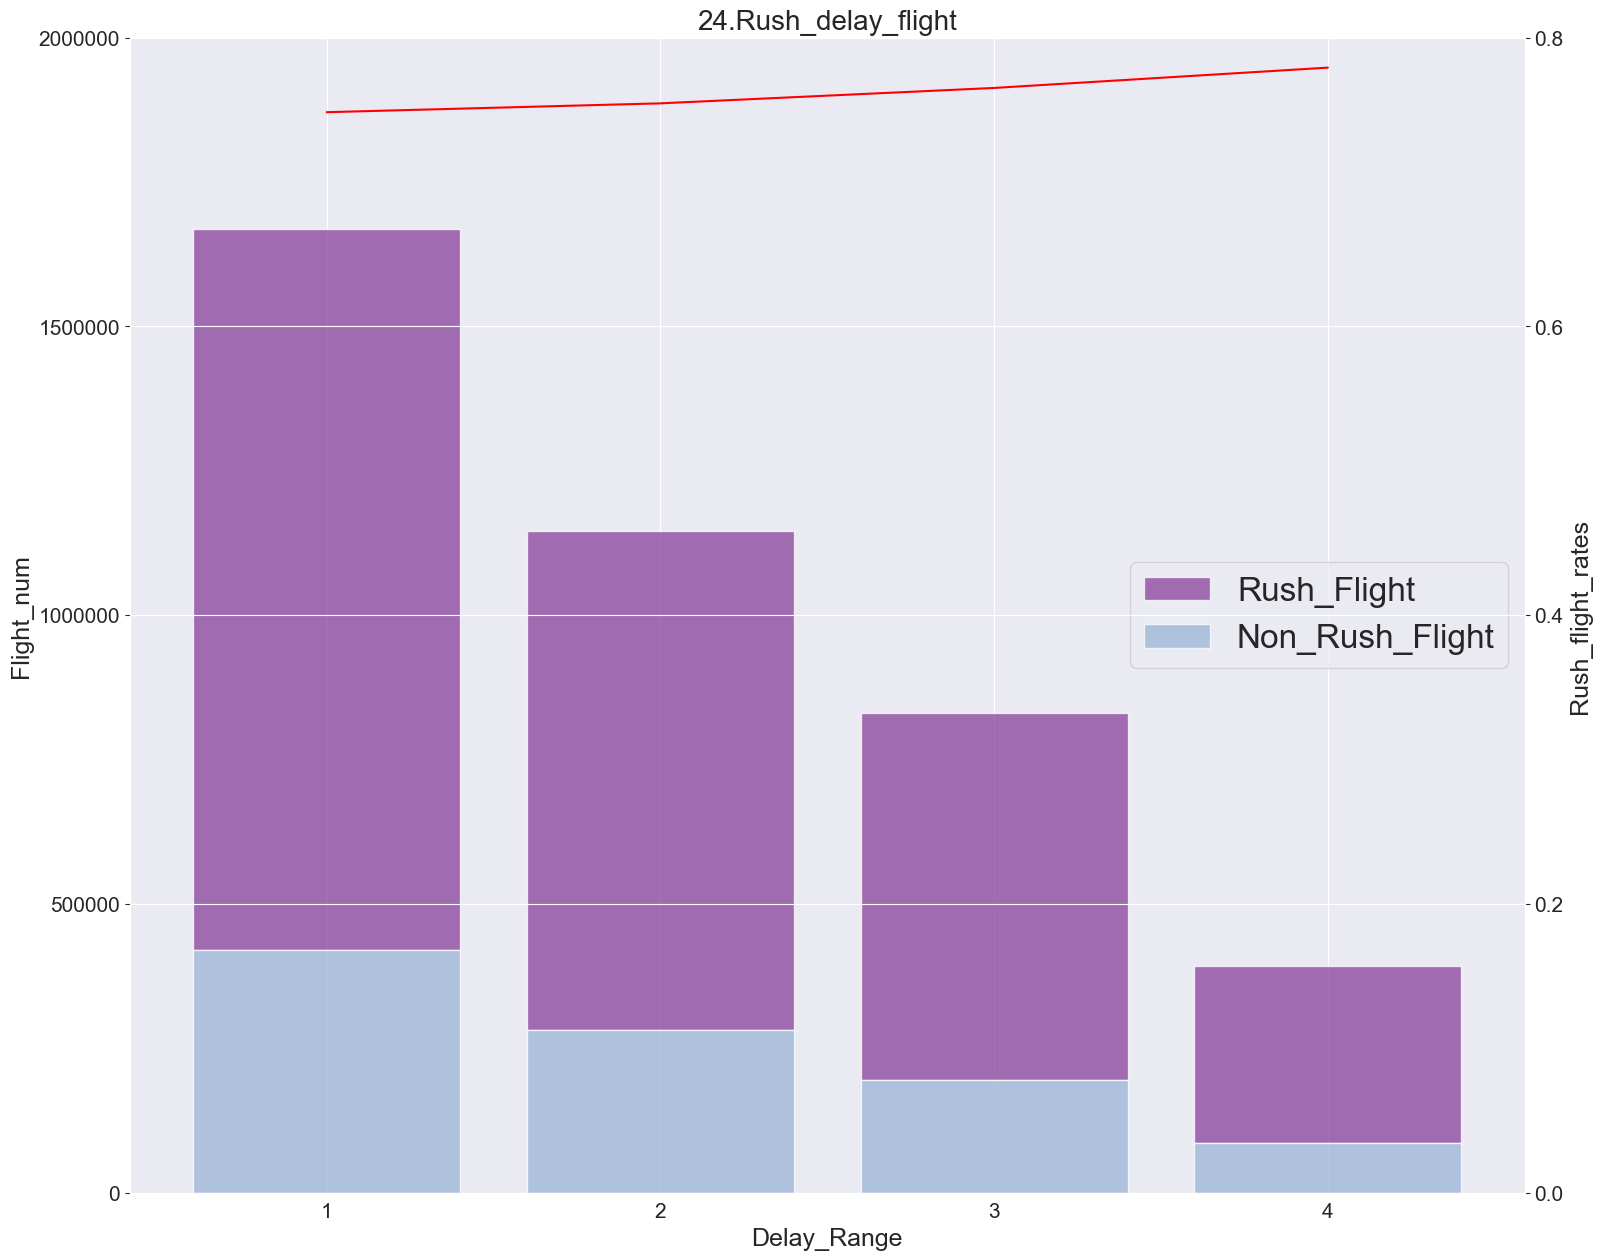

In [103]:
# plt.figure(figsize=(25, 10))
fig ,ax1 = plt.subplots(figsize=(18, 15))
color = 'red'
plt.title('24.Rush_delay_flight',fontsize=20)

colors = plt.cm.BuPu(np.linspace(0.4,0.75,2))
x = delay_counts_act_diff_plt[('delay_range', )][0:4] #各種起飛延誤級距
y1 = delay_counts_act_diff_plt[(  'delay_duration',  1)][0:4] #有趕飛
y0 = delay_counts_act_diff_plt[(  'delay_duration',  0)][0:4] #沒趕飛

plt.ticklabel_format(style='plain',axis='y')

plt.bar(x, y1, label='Rush_Flight', color=colors[1],alpha=0.75 ,tick_label=[1,2,3,4,],bottom=y0)
ax = plt.bar(x, y0, label='Non_Rush_Flight', color=colors[0], alpha=0.75 ,tick_label=[1,2,3,4,] )

ax1.set_xlabel('Delay_Range',fontsize=18)
ax1.set_ylabel('Flight_num',fontsize=18)
plt.tick_params(axis='y', which='both', labelsize=15)
plt.tick_params(axis='x', which='both', labelsize=15)
plt.yticks(np.linspace(0,2000000,5))
plt.ylim(0, 2000000)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, fontsize=24,markerscale=3,loc='center right')

ax2 = ax1.twinx()
ax2.set_ylabel('Rush_flight_rates',fontsize=18)
ax2 = sns.lineplot(data = delay_counts_act_diff_plt , x=delay_counts_act_diff_plt[('delay_range', )] , y=delay_counts_act_diff_plt[(  'delay_duration',  'Rush_flight_rates')], color=color )
ax2.tick_params(axis='y', which='both', labelsize=15)
plt.yticks(np.linspace(0,0.8,5),minor=False)
plt.ylim(0, 0.8)

plt.savefig('24.Rush_delay_flight_0416.png')


## 存出CSV

In [115]:
delay_counts_act_diff_plt[('delay_depa_cate', '')]

1    1
2    2
3    3
4    4
5    5
6    6
Name: (delay_depa_cate, ), dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [87]:
delay_counts_act_diff_plt.to_csv('24.Rush_delay_flight_0416.csv')

In [11]:
delay_counts['act_sche_diff'] = delay_counts['actu_duration'] - delay_counts['sche_duration']
delay_counts[['act_sche_diff']]

KeyError: 'sche_duration'